<a href="https://colab.research.google.com/github/koushikkirugulige/wyscout-data/blob/master/wyscout_xG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/koushikkirugulige/wyscout-data

Cloning into 'wyscout-data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 35 (delta 6), reused 7 (delta 1), pack-reused 19
Unpacking objects: 100% (35/35), done.


In [0]:
!unzip /content/wyscout-data/events.zip

Archive:  /content/wyscout-data/events.zip
  inflating: events_England.json     
  inflating: events_European_Championship.json  
  inflating: events_France.json      
  inflating: events_Germany.json     
  inflating: events_Italy.json       
  inflating: events_Spain.json       
  inflating: events_World_Cup.json   


In [0]:
#import all modules
import json
import os
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
from matplotlib.patches import Ellipse
from functools import reduce
import math

In [0]:
%%time
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('/content/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
data = events      
del events  

CPU times: user 27.5 s, sys: 5 s, total: 32.5 s
Wall time: 32.5 s


In [0]:
%%time
main_df = pd.DataFrame(data=None)
for nation in nations:
  df_tags = pd.json_normalize(data = data[nation],record_path ='tags', meta =['id'],record_prefix='tags')
  main_df = main_df.append(df_tags,ignore_index=True,sort=False) 
main_df.head()
df_tags = main_df
del main_df

CPU times: user 32.8 s, sys: 1.02 s, total: 33.9 s
Wall time: 33.9 s


In [0]:
goals_lst = df_tags.query('tagsid ==101')['id'].tolist()

In [0]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [0]:
%%time
main_df = pd.DataFrame(data=None)
for nation in nations:
  df = pd.DataFrame([flatten_json(x) for x in data[nation]])
  main_df = main_df.append(df,ignore_index=True,sort=False) 
df = main_df
del main_df  

CPU times: user 1min 9s, sys: 2.82 s, total: 1min 12s
Wall time: 1min 12s


In [0]:
df[(df['eventId'] == 10)  |  (df['subEventName'] == 'Penalty')]

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id
68,10,Shot,402.0,21077,41,80,0.0,0.0,2575959,Shot,3172,1H,193.924279,100,180424028,201.0,1203.0,1801.0,NaN,NaN
90,10,Shot,401.0,8327,33,95,100.0,100.0,2575959,Shot,3158,1H,250.843152,100,180424079,201.0,1210.0,1802.0,NaN,NaN
213,10,Shot,402.0,20879,63,72,100.0,100.0,2575959,Shot,3158,1H,633.577774,100,180424208,2101.0,1802.0,NaN,NaN,NaN
426,10,Shot,1901.0,23149,62,91,100.0,100.0,2575959,Shot,3158,1H,1359.469422,100,180424444,402.0,201.0,1210.0,1802.0,NaN
435,10,Shot,1901.0,295176,26,86,0.0,0.0,2575959,Shot,3172,1H,1412.601525,100,180424409,401.0,1216.0,1802.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250906,10,Shot,101.0,14943,53,92,100.0,100.0,2058017,Shot,9598,2H,1389.182669,100,263885208,402.0,201.0,1205.0,1801.0,NaN
3250992,10,Shot,402.0,69409,61,65,100.0,100.0,2058017,Shot,9598,2H,1802.299261,100,263885299,201.0,1211.0,1802.0,NaN,NaN
3251028,10,Shot,401.0,3476,33,81,100.0,100.0,2058017,Shot,9598,2H,1933.996341,100,263885348,2101.0,1802.0,NaN,NaN,NaN
3251155,10,Shot,401.0,28115,76,78,0.0,0.0,2058017,Shot,4418,2H,2487.443304,100,263885485,201.0,1204.0,1801.0,NaN,NaN


In [0]:
df_shot = df[(df['eventId'] == 10)]
df_shot.head()

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id
68,10,Shot,402.0,21077,41,80,0.0,0.0,2575959,Shot,3172,1H,193.924279,100,180424028,201.0,1203.0,1801.0,NaN,NaN
90,10,Shot,401.0,8327,33,95,100.0,100.0,2575959,Shot,3158,1H,250.843152,100,180424079,201.0,1210.0,1802.0,NaN,NaN
213,10,Shot,402.0,20879,63,72,100.0,100.0,2575959,Shot,3158,1H,633.577774,100,180424208,2101.0,1802.0,NaN,NaN,NaN
426,10,Shot,1901.0,23149,62,91,100.0,100.0,2575959,Shot,3158,1H,1359.469422,100,180424444,402.0,201.0,1210.0,1802.0,NaN
435,10,Shot,1901.0,295176,26,86,0.0,0.0,2575959,Shot,3172,1H,1412.601525,100,180424409,401.0,1216.0,1802.0,NaN,NaN


In [0]:
#some Penalty have x pos as 10 i.e was taken in the other side of the pitch
#Don't have to run this cell
df_shot.loc[df_shot['subEventName'] == 'Penalty', 'positions_0_x'] = 89
df_shot[df_shot['subEventName'] == 'Penalty']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id


In [0]:
df_shot['isGoal'] = False
df_shot.loc[df_shot.id.isin(goals_lst),'isGoal'] = True
df_shot.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id,isGoal
68,10,Shot,402.0,21077,41,80,0.0,0.0,2575959,Shot,3172,1H,193.924279,100,180424028,201.0,1203.0,1801.0,NaN,NaN,False
90,10,Shot,401.0,8327,33,95,100.0,100.0,2575959,Shot,3158,1H,250.843152,100,180424079,201.0,1210.0,1802.0,NaN,NaN,False
213,10,Shot,402.0,20879,63,72,100.0,100.0,2575959,Shot,3158,1H,633.577774,100,180424208,2101.0,1802.0,NaN,NaN,NaN,False
426,10,Shot,1901.0,23149,62,91,100.0,100.0,2575959,Shot,3158,1H,1359.469422,100,180424444,402.0,201.0,1210.0,1802.0,NaN,False
435,10,Shot,1901.0,295176,26,86,0.0,0.0,2575959,Shot,3172,1H,1412.601525,100,180424409,401.0,1216.0,1802.0,NaN,NaN,False


Lets plot a few shots and have a look


# **Wyscout Pitch** Diagram
https://figshare.com/articles/Plots_replication_code_of_Nature_Scientific_Data_paper/11473365

In [0]:
def pitch():
    """code to plot a soccer pitch"""
    #create figure
    fig,ax=plt.subplots(figsize=(10.4,6.8))

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="black")
    plt.plot([0,16.5],[80,80],color="black")
    plt.plot([16.5,0],[20,20],color="black")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="black")
    plt.plot([83.5,83.5],[80,20],color="black")
    plt.plot([83.5,100],[20,20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="black")
    plt.plot([5.5,5.5],[65,35],color="black")
    plt.plot([5.5,0.5],[35,35],color="black")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="black")
    plt.plot([94.5,94.5],[65,35],color="black")
    plt.plot([94.5,100],[35,35],color="black")

    """Author Koushik"""
    #Right Goal post
    plt.plot([100,100.4],[46,46],color="black")
    plt.plot([100,100.4],[54,54],color="black")
    plt.plot([100.4,100.4],[54,46],color="black")

    #Left Goal post
    plt.plot([0,-0.4],[46,46],color="black")
    plt.plot([0,-0.4],[54,54],color="black")
    plt.plot([-0.4,-0.4],[54,46],color="black")

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="black", facecolor="None", lw=1.8, zorder=2,alpha=1)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8, zorder=2,alpha=1)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8, zorder=2,alpha=1)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8, zorder=2,alpha=1)
    rec3 = plt.Rectangle((-0, -0), 100,100,ls='-',color='#195905', zorder=1,alpha=1)

    #Draw Circles
    ax.add_artist(rec3)
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #limit axis
    plt.xlim(-2,102)
    plt.ylim(-2,102)

    ax.annotate("", xy=(25, 5), xytext=(5, 5),
    arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.text(7,7,'Attack',fontsize=20)
    return fig,ax

In [0]:
df_shot[df_shot['subEventName'] == 'Penalty']['positions_0_x'].value_counts()

Series([], Name: positions_0_x, dtype: int64)

Visualize Goals

In [0]:
gol = df_shot[df_shot['isGoal'] ==True ]

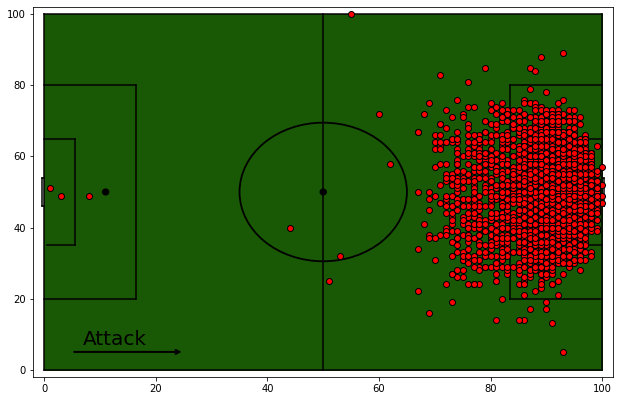

In [0]:
import matplotlib.pyplot as plt
pitch()

#plt.plot([65,65],[0,90], color="pink")

for i in range(len(gol)):
    xe = gol.iloc[i]['positions_0_x']
    ye = gol.iloc[i]['positions_0_y']
    g = plt.scatter(xe,ye,color="red",edgecolors="black",zorder=10,alpha=1)
plt.axis('on')
plt.show()    

What happened before the Shot ?

In [0]:
#subtract 1 from the shot id hope its True
arr = df_shot.index.to_numpy()
for i in range(len(arr)):
  arr[i] = arr[i] -1
len(arr)

43078

In [0]:
df_before_shot = df[df.index.isin(arr)]
#add one to id of df_before_shot so as to join to df_shot dataframe
#df_before_shot['id'] +=1
df_before_shot

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id
67,1,Ground attacking duel,504.0,21077,18,37,41.0,80.0,2575959,Duel,3172,1H,191.621429,11,180424027,703.0,1801.0,NaN,NaN,NaN
89,8,High pass,302.0,114,75,71,33.0,95.0,2575959,Pass,3158,1H,247.586484,83,180424076,901.0,1801.0,NaN,NaN,NaN
212,8,Simple pass,1801.0,23149,66,77,63.0,72.0,2575959,Pass,3158,1H,631.457147,85,180424207,NaN,NaN,NaN,NaN,NaN
425,8,Smart pass,302.0,44251,77,69,62.0,91.0,2575959,Pass,3158,1H,1357.201318,86,180424439,1901.0,1801.0,NaN,NaN,NaN
434,8,Simple pass,1901.0,21077,16,90,26.0,86.0,2575959,Pass,3172,1H,1411.238369,85,180424404,1801.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250905,1,Ground defending duel,501.0,14943,54,94,53.0,92.0,2058017,Duel,9598,2H,1388.157139,12,263885258,703.0,1801.0,NaN,NaN,NaN
3250991,8,Simple pass,1801.0,69968,20,57,61.0,65.0,2058017,Pass,9598,2H,1798.035328,85,263885297,NaN,NaN,NaN,NaN,NaN
3251027,7,Touch,NaN,69411,29,90,33.0,81.0,2058017,Others on the ball,9598,2H,1932.975578,72,263885346,NaN,NaN,NaN,NaN,NaN
3251154,1,Ground defending duel,501.0,69968,14,23,24.0,22.0,2058017,Duel,9598,2H,2484.797699,12,263885709,701.0,1802.0,NaN,NaN,NaN


Type of Pass which led to shot

In [0]:
# find the pass which led to shot if any
def pass_type(record):
  
  if record['subEventId'] == 80 or record['subEventId'] == 81 or record['subEventId'] == 82  or record['subEventId'] == 82  or record['subEventId'] == 84  or record['subEventId'] == 85 or record['subEventId'] == 86:   
    if record['subEventId'] == 80:
      return 1 #cross
    if record['subEventId'] == 81:
      return 2 #hand pass
    if record['subEventId'] == 82:
      return 3 #head pass
    if record['subEventId'] == 83:
      return 4 #high pass
    if record['subEventId'] == 84:
      return 5 #Launch
    if record['subEventId'] == 85:
      return 6 #simple pass
    return 7   #smart pass   
  return 0 #no pass

Type of Duel before Shot

In [0]:
duel_arr = [10,11,12,13]
def duel_type(record):
  if record['subEventId'] in duel_arr:
    if record['subEventId'] == 10:
      return 1
    if record['subEventId'] == 11:
      return 2
    if record['subEventId'] == 12:
      return 3
    if record['subEventId'] == 13:
      return 4  
  return 0 
#if record['subEventId'] == 80 or record['subEventId'] == 81 or record['subEventId'] == 82  or record['subEventId'] == 82  or record['subEventId'] == 84  or record['subEventId'] == 85 or record['subEventId'] == 86:   

Is Shot after a Freekick ?

In [0]:
freek_arr = [30,31,32,33,34,35,36]
def open_play(record):
  if record['subEventId'] in freek_arr:
    return 1
  return 0

In [0]:
df_before_shot['DuelType'] = df_before_shot.apply(duel_type,axis = 1)
df_before_shot['PassType'] = df_before_shot.apply(pass_type,axis = 1)
df_before_shot['OpenPlay'] = df_before_shot.apply(open_play,axis = 1)
df_before_shot.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id,DuelType,PassType,OpenPlay
67,1,Ground attacking duel,504.0,21077,18,37,41.0,80.0,2575959,Duel,3172,1H,191.621429,11,180424027,703.0,1801.0,NaN,NaN,NaN,2,0,0
89,8,High pass,302.0,114,75,71,33.0,95.0,2575959,Pass,3158,1H,247.586484,83,180424076,901.0,1801.0,NaN,NaN,NaN,0,0,0
212,8,Simple pass,1801.0,23149,66,77,63.0,72.0,2575959,Pass,3158,1H,631.457147,85,180424207,NaN,NaN,NaN,NaN,NaN,0,6,0
425,8,Smart pass,302.0,44251,77,69,62.0,91.0,2575959,Pass,3158,1H,1357.201318,86,180424439,1901.0,1801.0,NaN,NaN,NaN,0,7,0
434,8,Simple pass,1901.0,21077,16,90,26.0,86.0,2575959,Pass,3172,1H,1411.238369,85,180424404,1801.0,NaN,NaN,NaN,NaN,0,6,0


## **Coordinate** considered for right goal post (100,54) and (100,46)

In [0]:
def distFormula(coordinate):
  a =(math.sqrt(((coordinate.positions_0_x - 100)**2) + ((coordinate.positions_0_y - 46)**2))) 
  b =(math.sqrt(((coordinate.positions_0_x - 100)**2) + ((coordinate.positions_0_y - 54)**2))) 
  return ((a+b)/2)

**Angle formula here** 
https://stackoverflow.com/questions/1211212/how-to-calculate-an-angle-from-three-points

In [0]:
""" near x y (nx,ny) (100,54)and far x y (fx,fy) (100,46)""" 
nx = 100
ny = 54
fx = 100
fy = 46

goalpostLength = 8
def shot_angle(points):
  len1 = (math.sqrt(((points.positions_0_x - nx)**2) + ((points.positions_0_y - ny)**2))) 
  len2 = (math.sqrt(((points.positions_0_x - fx)**2) + ((points.positions_0_y - fy)**2)))
  ang = (len1**2 + len2**2 - goalpostLength**2)/(2 * len1 * len2)
  angRad = math.acos(ang)
  return( (angRad * 180)/math.pi) 

Shot Body part

In [0]:
#findout the body part with which shot was taken from
def shot_part(record):
  if record['tags_0_id'] == 401 or record['tags_1_id'] == 401 or record['tags_2_id'] == 401 or record['tags_3_id'] == 401 or record['tags_4_id'] == 401 or record['tags_5_id'] == 401:
    return 1 #left value
  elif record['tags_0_id'] == 402 or record['tags_1_id'] == 402 or record['tags_2_id'] == 402 or record['tags_3_id'] == 402 or record['tags_4_id'] == 402 or record['tags_5_id'] == 402:
    return 1 #right value
  elif record['tags_0_id'] == 403 or record['tags_1_id'] == 403 or record['tags_2_id'] == 403 or record['tags_3_id'] == 403 or record['tags_4_id'] == 403 or record['tags_5_id'] == 403:
    return 2 #head value    

If attack was a counter attack

In [0]:
# findout if shot was a result of counter attack
def playtype(record):
  if record['tags_0_id'] == 1901 or record['tags_1_id'] == 1901 or record['tags_2_id'] == 1901 or record['tags_3_id'] == 1901 or record['tags_4_id'] == 1901 or record['tags_5_id'] == 1901:
    return 1 #counter attack
  return 0  

In [0]:
%%time
df_shot['angle'] = df_shot.apply(shot_angle,axis = 1)
df_shot['Distance'] =  df_shot.apply(distFormula,axis = 1)
df_shot['body_part'] = df_shot.apply(shot_part,axis = 1)
df_shot['counterAttack'] = df_shot.apply(playtype,axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 10.7 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
df_shot = df_shot.join(df_before_shot,how='inner',rsuffix='bef_sht')
#pd.merge(df_shot,df_before_shot,how='inner',left_on = index, right_on=index)

In [0]:
df_shot.head()

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id,isGoal,angle,Distance,body_part,counterAttack,eventIdbef_sht,subEventNamebef_sht,tags_0_idbef_sht,playerIdbef_sht,positions_0_ybef_sht,positions_0_xbef_sht,positions_1_ybef_sht,positions_1_xbef_sht,matchIdbef_sht,eventNamebef_sht,teamIdbef_sht,matchPeriodbef_sht,eventSecbef_sht,subEventIdbef_sht,idbef_sht,tags_1_idbef_sht,tags_2_idbef_sht,tags_3_idbef_sht,tags_4_idbef_sht,tags_5_idbef_sht,DuelType,PassType,OpenPlay
67,10,Shot,402.0,21077,41,80,0.0,0.0,2575959,Shot,3172,1H,193.924279,100,180424028,201.0,1203.0,1801.0,NaN,NaN,False,18.987624,22.234625,1,0,1,Ground attacking duel,504.0,21077,18,37,41.0,80.0,2575959,Duel,3172,1H,191.621429,11,180424027,703.0,1801.0,NaN,NaN,NaN,2,0,0
89,10,Shot,401.0,8327,33,95,100.0,100.0,2575959,Shot,3158,1H,250.843152,100,180424079,201.0,1210.0,1802.0,NaN,NaN,False,7.645013,17.757711,1,0,8,High pass,302.0,114,75,71,33.0,95.0,2575959,Pass,3158,1H,247.586484,83,180424076,901.0,1801.0,NaN,NaN,NaN,0,0,0
212,10,Shot,402.0,20879,63,72,100.0,100.0,2575959,Shot,3158,1H,633.577774,100,180424208,2101.0,1802.0,NaN,NaN,NaN,False,13.444843,31.083781,1,0,8,Simple pass,1801.0,23149,66,77,63.0,72.0,2575959,Pass,3158,1H,631.457147,85,180424207,NaN,NaN,NaN,NaN,NaN,0,6,0
425,10,Shot,1901.0,23149,62,91,100.0,100.0,2575959,Shot,3158,1H,1359.469422,100,180424444,402.0,201.0,1210.0,1802.0,NaN,False,19.008707,15.199577,1,1,8,Smart pass,302.0,44251,77,69,62.0,91.0,2575959,Pass,3158,1H,1357.201318,86,180424439,1901.0,1801.0,NaN,NaN,NaN,0,7,0
434,10,Shot,1901.0,295176,26,86,0.0,0.0,2575959,Shot,3172,1H,1412.601525,100,180424409,401.0,1216.0,1802.0,NaN,NaN,False,8.426969,27.859031,1,1,8,Simple pass,1901.0,21077,16,90,26.0,86.0,2575959,Pass,3172,1H,1411.238369,85,180424404,1801.0,NaN,NaN,NaN,NaN,0,6,0


# **Building xG Model/s**

Importing Required ML models

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn import linear_model

In [0]:
xgModel = df_shot[['Distance','angle','isGoal','body_part','counterAttack','positions_0_x','positions_0_y','DuelType',	'PassType',	'OpenPlay']]

In [0]:
X_train,X_test,y_train,y_test = train_test_split(xgModel[['Distance','angle','body_part','counterAttack','positions_0_x','positions_0_y','DuelType',	'PassType',	'OpenPlay']],xgModel['isGoal'],test_size = 0.2,shuffle = True)

**Logistic Regression** for xG

In [0]:
clf = LogisticRegression(random_state=0,max_iter = 5000).fit(X_train, y_train)

In [0]:
#model weights
clf.coef_[0]

array([-0.07860825,  0.020428  , -0.87442354,  0.59938498,  0.06113528,
       -0.00281177, -0.02426686,  0.04170474, -0.37948765])

In [0]:
xG = clf.predict_proba(X_test)[:,1]

**SGDClassifier** for xG with fine tuning alpha parameter

In [0]:
sgdclf = linear_model.SGDClassifier(loss='log', alpha = 0.17)
sgdclf.fit(X_train, y_train)

SGDClassifier(alpha=0.17, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
xG = sgdclf.predict_proba(X_test)[:,1]

SVM for xG

In [0]:
X_test['xG'] = xG
X_test.head()

,Distance,angle,body_part,counterAttack,positions_0_x,positions_0_y,DuelType,PassType,OpenPlay,xG
966916,24.931118,13.561052,1,1,82,67,0,6,0,0.071241
1166231,10.810323,43.264295,1,0,90,49,0,1,0,0.327973
78961,17.904326,17.912509,1,0,88,37,0,6,0,0.172423
1708857,26.046409,6.911227,2,0,90,26,0,0,1,0.049128
988619,35.458271,3.691386,1,0,90,16,0,6,0,0.026513


True Test for model ?

In [0]:
sortxg = X_test.sort_values(by = ['xG'],ascending=False)
sortxg

,Distance,angle,body_part,counterAttack,positions_0_x,positions_0_y,DuelType,PassType,OpenPlay,xG
738061,4.000000,180.000000,1,0,100,47,0,6,0,0.915751
168627,4.130649,150.255119,1,0,99,49,0,3,0,0.853545
3036483,4.130649,150.255119,1,0,99,51,0,3,0,0.852571
590983,4.130649,150.255119,1,0,99,51,0,0,0,0.831066
2533518,4.130649,150.255119,1,0,99,51,0,0,0,0.831066
...,...,...,...,...,...,...,...,...,...,...
3119854,68.380383,6.681202,1,0,32,56,0,6,0,0.000354
565770,70.073190,5.240966,2,0,44,92,1,0,0,0.000192
1767939,78.073335,4.747234,2,0,37,4,1,0,0,0.000103
2203892,91.873429,4.947982,1,1,9,62,0,7,0,0.000021


In [0]:
for i in range(10):
  print(sortxg.iloc[i]['xG'])

0.9157510419607181
0.853544661355994
0.8525705544578612
0.8310656822839603
0.8310656822839603
0.8310656822839603
0.8310656822839603
0.8300543425631743
0.8248330388192454
0.8227661043411246


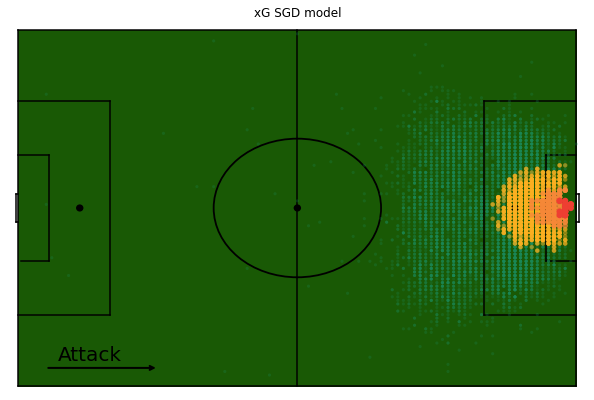

In [0]:
import matplotlib.pyplot as plt
pitch()

#plt.plot([65,65],[0,90], color="pink")

for i in range(len(sortxg)):
    xe = sortxg.iloc[i]['positions_0_x']
    ye = sortxg.iloc[i]['positions_0_y']
    if sortxg.iloc[i]['xG'] >= 0.75:
      g = plt.scatter(xe,ye,color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
    elif sortxg.iloc[i]['xG'] < 0.75 and sortxg.iloc[i]['xG'] >=0.5:
      g = plt.scatter(xe,ye,color="#f68838",edgecolors="none",zorder=8,alpha=0.75,s = 30 )
    elif sortxg.iloc[i]['xG'] < 0.5 and sortxg.iloc[i]['xG'] >=0.25:
      g = plt.scatter(xe,ye,color="#fbb021",edgecolors="none",zorder=6,alpha=0.5,s = 20 )  
    else:
      g = plt.scatter(xe,ye,color="#1b8a5a",edgecolors="none",zorder=4,alpha=0.25,s = 10 )    
plt.axis('off')
plt.title('xG SGD model')
plt.savefig('xgSGDmodel.png')
plt.show()

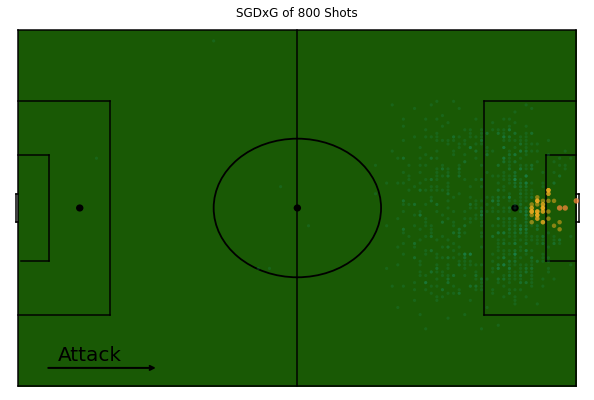

In [0]:
import matplotlib.pyplot as plt
pitch()

#plt.plot([65,65],[0,90], color="pink")

for i in range(800):
    xe = X_test.iloc[i]['positions_0_x']
    ye = X_test.iloc[i]['positions_0_y']
    if X_test.iloc[i]['xG'] >= 0.75:
      g = plt.scatter(xe,ye,color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
    elif X_test.iloc[i]['xG'] < 0.75 and X_test.iloc[i]['xG'] >=0.5:
      g = plt.scatter(xe,ye,color="#f68838",edgecolors="none",zorder=8,alpha=0.75,s = 30 )
    elif X_test.iloc[i]['xG'] < 0.5 and X_test.iloc[i]['xG'] >=0.25:
      g = plt.scatter(xe,ye,color="#fbb021",edgecolors="none",zorder=6,alpha=0.5,s = 20 )  
    else:
      g = plt.scatter(xe,ye,color="#1b8a5a",edgecolors="none",zorder=4,alpha=0.25,s = 10 )    
plt.axis('off')
plt.title('SGDxG of 800 Shots')
plt.savefig('SGDxG800shots.png')
plt.show()    

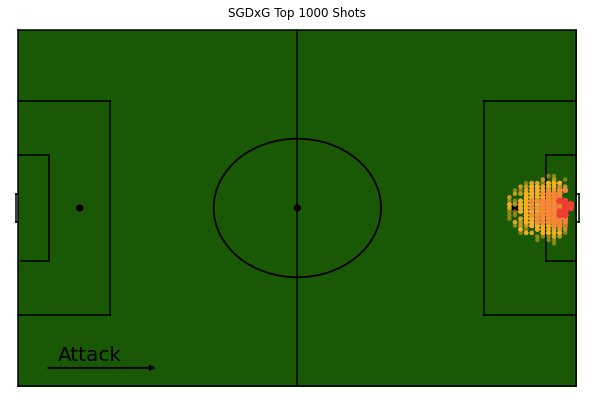

In [0]:
import matplotlib.pyplot as plt
pitch()

#plt.plot([65,65],[0,90], color="pink")

for i in range(1000):
    xe = sortxg.iloc[i]['positions_0_x']
    ye = sortxg.iloc[i]['positions_0_y']
    if sortxg.iloc[i]['xG'] >= 0.75:
      g = plt.scatter(xe,ye,color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
    elif sortxg.iloc[i]['xG'] < 0.75 and sortxg.iloc[i]['xG'] >=0.5:
      g = plt.scatter(xe,ye,color="#f68838",edgecolors="none",zorder=8,alpha=0.75,s = 30 )
    elif sortxg.iloc[i]['xG'] < 0.5 and sortxg.iloc[i]['xG'] >=0.25:
      g = plt.scatter(xe,ye,color="#fbb021",edgecolors="none",zorder=6,alpha=0.5,s = 20 )  
    else:
      g = plt.scatter(xe,ye,color="#1b8a5a",edgecolors="none",zorder=4,alpha=0.25,s = 10 )    
plt.axis('off')
plt.title('SGDxG Top 1000 Shots')
plt.savefig('SGDxGtop1000shots.png')
plt.show()

# Save Model using Pickle

In [0]:
import pickle
  
# Save the model as a pickle in a file 
f = open('SGDparamsxG.pkl','wb')
pickle.dump(sgdclf, f)

Predict Kaka shot and penalty

In [0]:
#['Distance','angle','body_part','counterAttack','positions_0_x','positions_0_y','DuelType',	'PassType',	'OpenPlay']
sgdclf.predict_proba(np.array([11,39.699073,1,0,89,51,0,0,0]).reshape(1, -1))[:,1]

array([0.31594881])

In [0]:
nx = 100
ny = 54
fx = 100
fy = 46

goalpostLength = 8
len1 = (math.sqrt(((90 - nx)**2) + ((51 - ny)**2))) 
len2 = (math.sqrt(((90 - fx)**2) + ((51 - fy)**2)))
ang = (len1**2 + len2**2 - goalpostLength**2)/(2 * len1 * len2)
angRad = math.acos(ang)
print( (angRad * 180)/math.pi) 

43.264295411071615
